In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras import layers

import gensim
# import gensim.downloader as api
# from gensim.models import Word2Vec

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
Using TensorFlow backend.


In [ ]:
# word_vectors = api.load("glove-twitter-200")

In [3]:
# import data
raw_data =  pd.read_csv('../raw-data/skills_test.csv')

In [4]:
raw_data.head()

,Text,label
0,I bought a car through a dealership and had so...,1
1,"April 7, 2006 Wells Fargo Bank announced they ...",1
2,Securities watchdog investigates Wells Fargo o...,1
3,I had a problem where for months my student lo...,1
4,If someone opens a bank account without your k...,1


In [5]:
# Check balance of the two classes
print(raw_data[raw_data['label'] == 0]['label'].count())
print(raw_data[raw_data['label'] == 1]['label'].count())

1914
1914


In [6]:
def clean_text(s):
    """
    Pre-process text data by removing stop words, puncuation and strange characters
    
    return string
    """
    lemma = WordNetLemmatizer()
    symbols_re = re.compile('[^a-z #+_]')
    space_re = re.compile('[/(){}\[\]\|@,;]')
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = s.lower()
    s = symbols_re.sub('', s)
    s = space_re.sub(' ', s)
    s = ' '.join([l for l in s.split() if l not in stopwords.words('english')])
    normalized = " ".join(lemma.lemmatize(word) for word in s.split())
    return normalized

In [7]:
def plot_cm(cf):
    """
    Plot the confusion matrix
    """
    plt.matshow(cf)
    plt.title('Confusion Matrix Plot')
    plt.colorbar()
    plt.xlabel('Precited')
    plt.ylabel('Actual')
    plt.show()

In [8]:
def tokenize_CountVectorizer(text_train, text_test, all_text):
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=None)
    vectorizer.fit(text_train)
    X_train = vectorizer.transform(text_train)
    X_test  = vectorizer.transform(text_test)
    text_vects = vectorizer.transform(all_text)
    return X_train, X_test, text_vects 

In [9]:
def tokenize_tfidf(text_train, text_test, all_text):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(text_train)
    X_train = vectorizer.transform(text_train)
    X_test  = vectorizer.transform(text_test)
    text_vects = vectorizer.transform(all_text)
    return X_train, X_test, text_vects 

In [10]:
def word_embedding(word_vectors,text_train, text_test, all_text):
    dimsize = 200
    # tokenize sentences
    X_train = text_train.apply(lambda x: nltk.word_tokenize(x))
    X_train = X_train.apply(lambda x: np.array([avg_word_vectors(word_vectors,w,200) for w in x]).mean(axis=0)[0])
    X_train = np.vstack((X_train))
    
    X_test = text_test.apply(lambda x: nltk.word_tokenize(x))
    X_test = X_test.apply(lambda x: np.array([avg_word_vectors(word_vectors,w,200) for w in x]).mean(axis=0)[0])
    X_test = np.vstack((X_test))
    
    text_vects = raw_data['Text'].apply(lambda x: nltk.word_tokenize(x))
    text_vects = text_vects.apply(lambda x: np.array([avg_word_vectors(word_vectors,w,200) for w in x]).mean(axis=0)[0])
    text_vects = np.vstack((text_vects))
    return  X_train, X_test, text_vectors

In [11]:
def avg_word_vectors(model,wordlist,size):
    """
    returns a vector of zero for text containing words where none of them
    met the min_count or were not seen in the training set
    Otherwise return an average of the embeddings vectors
    """
    sumvec = np.zeros(shape=(1,size))
    wordcnt = 0
    for w in wordlist:
        if w in model:
            sumvec += model[w]
            wordcnt +=1

        if wordcnt == 0:
            print(w)
            return sumvec
        else:
            return sumvec / wordcnt

In [12]:
def classifier(classifier_method, X_train, X_test, y_train, y_test, text_vects):
# nb = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('clf', MultinomialNB()),
#               ])

    classifier = classifier_method
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))
    cf = confusion_matrix(y_test, y_pred)
    scores = cross_val_score(classifier, text_vects, raw_data['label'], cv=10)
    print('Average score from cross-validation {}'.format(scores.mean()))
    plot_cm(cf)
    return

In [13]:
# logger.info('cleaning text, this may take 1-2 minutes...')
raw_data['Text'] = raw_data['Text'].apply(clean_text)

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - '/home/msinxi/nltk_data'
    - '/home/msinxi/kantar_application/env/nltk_data'
    - '/home/msinxi/kantar_application/env/share/nltk_data'
    - '/home/msinxi/kantar_application/env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


split the data into training set and test set using scikitlearn

In [13]:
x = raw_data['Text']
y = raw_data['label']
text_train, text_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [1]:
X_train, X_test, text_vects = tokenize_CountVectorizer(text_train, text_test, raw_data['Text'])

NameError: name 'tokenize_CountVectorizer' is not defined

In [182]:
X_train, X_test, text_vects = tokenize_tfidf(text_train, text_test, raw_data['Text'])

In [ ]:
X_train, X_test, text_vects = word_embedding(word_vectors, text_train, text_test, raw_data['Text'])

In [89]:
## Naive Bayes Classifier for Multinomial Models
classifier(MultinomialNB(), X_train, X_test, y_train, y_test, text_vects)

ValueError: setting an array element with a sequence.

accuracy 0.6405570060922542
              precision    recall  f1-score   support

           0       0.61      0.78      0.69       577
           1       0.69      0.50      0.58       572

    accuracy                           0.64      1149
   macro avg       0.65      0.64      0.63      1149
weighted avg       0.65      0.64      0.63      1149

Average score from cross-validation 0.6082051701570681


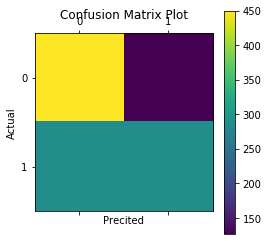

In [127]:
# Linear Support Vector Machine
classifier(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, tol=None), 
           X_train, X_test, y_train, y_test, text_vects)

accuracy 0.6884247171453438
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       577
           1       0.67      0.74      0.70       572

    accuracy                           0.69      1149
   macro avg       0.69      0.69      0.69      1149
weighted avg       0.69      0.69      0.69      1149

Average score from cross-validation 0.6656236365619546


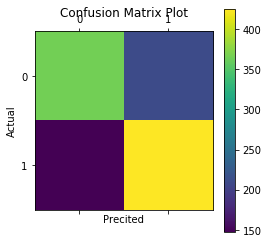

In [128]:
## Linear Support Vector Machine
classifier(LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=200),
           X_train, X_test, y_train, y_test, text_vects)

accuracy 0.6840731070496083
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       577
           1       0.66      0.74      0.70       572

    accuracy                           0.68      1149
   macro avg       0.69      0.68      0.68      1149
weighted avg       0.69      0.68      0.68      1149

Average score from cross-validation 0.6674833660558463


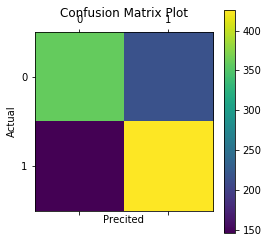

In [129]:
## Decision Tree
classifier(DecisionTreeClassifier(max_depth=10,random_state=0), 
           X_train, X_test, y_train, y_test, text_vects)

accuracy 0.7267188859878155
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       577
           1       0.76      0.66      0.71       572

    accuracy                           0.73      1149
   macro avg       0.73      0.73      0.73      1149
weighted avg       0.73      0.73      0.73      1149

Average score from cross-validation 0.7042539267015708


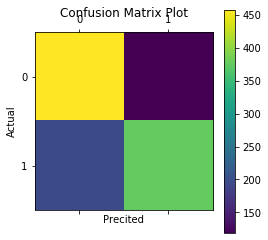

In [130]:
## Random Forrest Classifier
classifier( RandomForestClassifier(n_estimators=10, max_depth=None,random_state=0),
           X_train, X_test, y_train, y_test, text_vects)

## Neural Networks in Keras with Tensorflow in the backend

In [131]:
num_feat = X_train.shape[1]
model = Sequential()
model.add(layers.Dense(10, input_dim=num_feat, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [132]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                2010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [140]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [141]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7197
Testing Accuracy:  0.6945


In [142]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

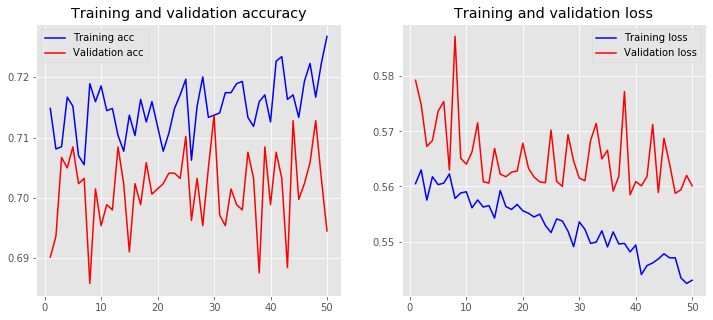

In [143]:
plot_history(history)